In [1]:

from find_prices_nonoverlap import *
from sklearn import metrics
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score)
import warnings
warnings.filterwarnings(action='once')

In [3]:
df = pd.read_csv('single_family_home_values.csv')

print('Preparing Data: cleaning data')
not_useful_fields = ['id','city','state']#, 'address']
date_fields = ['lastSaleDate', 'priorSaleDate']
required_fields = ['address','latitude','longitude','zipcode','bedrooms',
                   'bathrooms','rooms','squareFootage',
                   'lotSize','yearBuilt',
                   'lastSaleDate','estimated_value']
zero_to_nan_fields = None
nan_to_zero_fields = ['priorSaleDate','priorSaleAmount']
# categorical_fields = ['zipcode']
remove_outliers=False
df2, new_fields = prepare_data(df, not_useful_fields=not_useful_fields,
        date_fields=date_fields,
        remove_outliers=remove_outliers,
        required_fields=required_fields,
        zero_to_nan_fields=zero_to_nan_fields,
        nan_to_zero_fields=nan_to_zero_fields,
        )
#         categorical_fields=categorical_fields,
print('Preparing Data: splitting test/train/validation')
df_train, df_test, df_validation = train_validate_test_split(df2)

X_test = df_test[df_test.columns.drop('estimated_value')]
y_test = df_test['estimated_value']

X = df_train[df_train.columns.drop('estimated_value')]
y = df_train['estimated_value'] 

Preparing Data: cleaning data
Nulling field priorSaleDate


find_prices_nonoverlap.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[field][pd.isnull(df[field])] = 0


Nulling field priorSaleAmount
Preparing Data: splitting test/train/validation


In [4]:
from sklearn.ensemble import (
    ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor 
)

print("Setting up pipeline")
features = ('latitude', 'longitude', 'zipcode',
            'bedrooms', 'bathrooms','rooms', 
            'squareFootage', 'lotSize', 
            'yearBuilt',
            'lastSaleAmount','lastSaleDateYear','lastSaleDateMonth','lastSaleDateDayOfWeek')


#: Note imputer will strip away column heads, it has to be after featurize
#reg_function = LGBMRegressor()
#reg_function = XGBRegressor()
reg_function = RandomForestRegressor(n_jobs=3)
#reg_function = GradientBoostingRegressor()
#reg_function = ExtraTreesRegressor(n_estimators=2)
#reg_function = AdaBoostRegressor(); #Really bad
pipeline = Pipeline([
          ('featurize', featurize(features)),
          ('imputer', Imputer(missing_values=np.nan, strategy="mean", axis=0)),
          ('forest', reg_function,)
            ])


Setting up pipeline


Fitting model on training data
Evaluating model on training data
73543.1923785
28193.4995439
0.97912794412
0.0382840815357


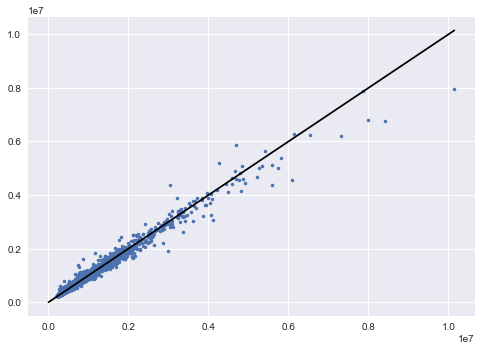

Evaluating model on testing data


ValueError: zipcode: y contains new labels: [80033 80202]

In [7]:

    
print("Fitting model on training data")
model = pipeline.fit(X = X, y = y)

print("Evaluating model on training data")
y_pred = model.predict(X)
print_metrics(y, y_pred)
plt.plot((y), (y_pred),'.')
y_max = (np.max((y, y_pred)))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

print("Evaluating model on testing data")
y_test_pred = model.predict(X_test)
print_metrics(y_test, y_test_pred)
plt.plot((y_test), (y_test_pred),'.', alpha=0.2)
y_max = (np.max((y_test, y_test_pred)))
plt.plot((0,y_max), (0,y_max),color='black')
plt.plot((0,y_max), (0,y_max*1.05),color='red')
plt.plot((0,y_max), (0,y_max*0.95),color='red')
plt.xlim(0,1e6)
plt.ylim(0,1e6)
plt.show()

In [ ]:
[c,b] = np.histogram(y_pred-y, bins=np.linspace(-1e6,1e6,100))
print(np.mean(y_pred-y))
plt.plot(b[:-1],c)
plt.show()

In [ ]:

sns.distplot(np.log(df['lastSaleAmount'].values+1))
 plt.show()


In [ ]:
#: Work on using grid-searches
params = {'forest__n_estimators':  (39,42)}
# params = {'forest__n_estimators':  np.arange(3,31,3)}
from sklearn.preprocessing import FunctionTransformer
# transformer = FunctionTransformer(np.log1p)
# transformer.transform(y)
grid = GridSearchCV(pipeline, params)
grid.fit(X = X, y = y)

#: Definining a specified cross-validation technique
cv= StratifiedKFold(n_splits=2)

# Alternatively, can say can say cv=3 to say a 3-repeat cross-validator
grid_search = GridSearchCV(pipeline, params)#, cv=cv)
#gsearch = GridSearchCV(pipeline, params)
grid_search.fit(X = X, y = y)
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

In [ ]:
best_pipeline = grid_search.best_estimator_
best_pipeline.get_params()['forest']

In [ ]:
X = X_test
y=y_test
y_pred = best_pipeline.predict(X)
print(np.sqrt(metrics.mean_squared_error(y,y_pred)))
print(metrics.mean_absolute_error(y,y_pred))
print(metrics.r2_score(y,y_pred))
print(abs_mean_relative_error(y,y_pred))
plt.plot(y, y_pred,'.')
y_max = np.max((y, y_pred))
plt.plot((0,y_max), (0,y_max),color='black')
plt.show()

In [124]:
lat_long_df = pd.groupby(df_train,'zipcode')['latitude','longitude'].mean()#.latitude.mean()
# pd.groupby(df,'zipcode').latitude.mean()

In [69]:
jj = lat_long_df.add_suffix('_mean')#.reset_index()

In [133]:
def calc_distance(df1, df2):
    
    
        min_dist = gcd_vec(df1['latitude'],df1['longitude'],df2['latitude'],df2['longitude'])
    
def give_nearest_zip(df_w_unseen_zipcode, lat_long_df):
    

SyntaxError: invalid syntax (<ipython-input-133-d49ad2461a4b>, line 1)

In [141]:
df_test[~df_test['zipcode'].isin(lat_long_df.index)][['latitude','longitude']]
lat_long_df[['latitude','longitude']].applymap(lambda x:gcd_vec(*x, target_lat, target_long), axis=1)

SyntaxError: only named arguments may follow *expression (<ipython-input-141-8f465f28ebb5>, line 1)

In [290]:
dd = df_test[~df_test['zipcode'].isin(lat_long_df.index)][['latitude','longitude']]

ndx =(dd[['latitude','longitude']]).reset_index().apply(lambda x: smallest_gcd_distance_ndx(
    lat_long_df.latitude.values, lat_long_df.longitude.values, x[0],x[1]), axis=1)
print(lat_long_df.iloc[ndx].index)
print(df_test[~df_test['zipcode'].isin(lat_long_df.index)][['latitude','longitude']] )
df_test.loc[~df_test['zipcode'].isin(lat_long_df.index),'zipcode'] = lat_long_df.iloc[ndx].index


Int64Index([80123], dtype='int64', name=u'zipcode')
      latitude   longitude
188  39.757914 -104.998132


In [291]:
df_test[~df_test['zipcode'].isin(lat_long_df.index)][['latitude','longitude']]

,latitude,longitude


In [279]:
dd = df_test[~df_test['zipcode'].isin(lat_long_df.index)][['latitude','longitude']]

np.argmin(gcd_vec(np.array([1,2,3]),np.array([1,2,3]),2,2))

1

In [181]:
lat_long_df.latitude.values, lat_long_df.longitude.values, 

array([ 39.84916   ,  39.62443184,  39.72404268,  39.73178965,
        39.75989409,  39.73223225,  39.75695276,  39.70524469])

In [283]:
        zip_code_lat_long_df = \
            pd.groupby(df,'zipcode')['latitude','longitude'].mean().add_suffix('_mean')

In [278]:
ndx =(dd[['latitude','longitude']]).reset_index().apply(lambda x: smallest_gcd_distance_ndx(
    lat_long_df.latitude.values, lat_long_df.longitude.values, x[0],x[1]), axis=1)
print(lat_long_df.iloc[ndx].index)


Int64Index([80123], dtype='int64', name=u'zipcode')


In [247]:
ndx.values

array([1, 0])

In [230]:
dd[['latitude','longitude']].reset_index().apply(lambda x: x[1]+x[2],axis=1)

0   -65.240218
1   -65.320280
dtype: float64

,zipcode,latitude,longitude
0,80022,39.849160,-104.893468
1,80123,39.624432,-105.081898
2,80203,39.724043,-104.981699
3,80204,39.731790,-105.030617
4,80205,39.759894,-104.962481
5,80206,39.732232,-104.951113
6,80207,39.756953,-104.922012
7,80209,39.705245,-104.967768


In [211]:
sales = [{'index': '188', 'lat': 150, 'long': 200},
         {'index': '3',  'lat': 200, 'long': 210}]
dfj = pd.DataFrame(sales)
print(dfj)
dfj[['lat','long']].apply(lambda x: x[0] + x[1])

  index  lat  long
0   188  150   200
1     3  200   210


lat     350
long    410
dtype: int64

In [222]:
dfj

,index,lat,long
0,188,150,200
1,3,200,210


In [293]:
from find_prices_nonoverlap import *

In [2]:
tzip = TransformZipCodes()

In [ ]:
tzip.fit()